<a href="https://colab.research.google.com/github/comradearya/MachineLearning/blob/main/%D0%9A%D0%9F_1_%D0%9F%D0%B0%D0%BD%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%9E_%D0%9F%D0%BE%D0%BD%D0%BE%D0%BC%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%86_%D0%86%D0%9A_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%matplotlib inline

Використаний датасет має наступні класи:‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Усі зображення розміром 3x32x32

План тренування моделі для розпізнавання
----------------------------

1. Завантажуємо та нормалізуємо датасет, тестуємо датасет використовуючи torchvision.
2. Визначаємо нейронну мережу згортки
3. Визначаємо функцію втрат
4. Навчаємо мережу на даних навчання
5. Перевіяємо мережу за тестовими даними

1. Завантажуємо та нормалізуємо CIFAR10
----------------------------

Використовуючи ``torchvision``, це зробити дуже легко.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms


Вивід - це PILImage зображення в діапазоні від [0, 1].
Трансформуємо їх у Тезори з нормалізованим діапазоном [-1, 1].

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



Просто подивимося, що ми завантажили.



  dog  bird  bird  bird


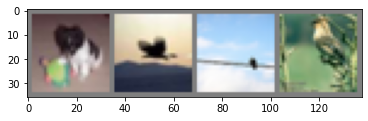

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# функції щоб побачити зображення


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# дістати декілька рандомних тренувальних зображень 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# побачити зображення
imshow(torchvision.utils.make_grid(images))
# виводимо назви класів
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Визначаємо нейрону мережу згротки
-------------------------------------------------
Скопіюйте нейронну мережу та замінемо її на 3-канальні зображення замість 1-канальних, як було заявлено раніше.


In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Визначаємо функцію витрат та оптимізатор
-------------------
Використаємо класифікацію перехресних ентропійних втрат і SGD з імпульсом.



In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

*4*. Тренуємо мережу
^^^^^^^^^^^^^^^^^^^^

Саме зараз все починає ставати цікавішим.
Нам просто потрібно обійти наш ітератор даних і передати вхідні дані до мережі та оптимізувати.



In [17]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Тренування завершено')

[1,  2000] loss: 2.193
[1,  4000] loss: 1.825
[1,  6000] loss: 1.646
[1,  8000] loss: 1.553
[1, 10000] loss: 1.509
[1, 12000] loss: 1.488
[2,  2000] loss: 1.395
[2,  4000] loss: 1.364
[2,  6000] loss: 1.328
[2,  8000] loss: 1.317
[2, 10000] loss: 1.284
[2, 12000] loss: 1.257
Тренування завершено


5. Тестуємо мережу на тестових даних 
---
Ми навчали мережу за 2 проходи над набором навчальних даних.
Але нам потрібно перевірити, чи мережа взагалі чогось навчилася.

Ми перевіримо це, передбачивши мітку класу нейронної мережі
вихідні дані та перевірка їх на відповідність заземленій істині. Якщо передбачення є
правильно, ми додаємо зразок до списку правильних передбачень.

Добре, перший крок. Давайте покажемо зображення з тестового набору, щоб познайомитися.



GroundTruth:    cat  ship  ship plane


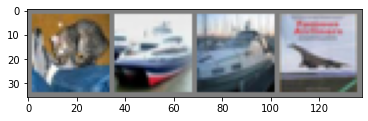

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


Виведемо як нейронна мережа бачить зображення вгорі:


In [19]:
outputs = net(images)

Вихідними є енергії для 10 класів.
Чим вища енергія для класу, тим більше мережа
вважає, що зображення належить до певного класу.
Отже, отримаємо індекс найвищої енергії:

In [20]:
_, predicted = torch.max(outputs, 1)

print('Очікується: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Очікується:    cat  ship  ship plane


Результати є доволі непогані

Тепер спробуємо зрозуміти, як нейронка оброблює весь датасет.

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Точність нейронної мережі на 10000 тестових зображень: %d %%' % (
    100 * correct / total))

Точність нейронної мережі на 10000 тестових зображень: 55 %


Усе виглядає набагато краще, ніж випадковість, яка становить 10% точності (випадковий вибір
класу з 10 класів).
Здається, мережа чогось навчилася.

Подивимося, по класам, яка точність в кожного:

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Точність %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Точність plane : 64 %
Точність   car : 69 %
Точність  bird : 38 %
Точність   cat : 36 %
Точність  deer : 30 %
Точність   dog : 42 %
Точність  frog : 62 %
Точність horse : 69 %
Точність  ship : 75 %
Точність truck : 69 %
